# 3. Thermophysical properties from the FE-ANN(s) EoS

The FE-ANN(s) EoS models the Helmholtz free energy of the Mie particle. 

$$ \mathcal{U}^{\mathrm{Mie}} = \mathcal{C}^{\mathrm{Mie}} \epsilon \left[ \left(\frac{\sigma}{r}\right)^{\lambda_r} -  \left(\frac{\sigma}{r}\right)^{\lambda_a} \right] $$

This EoS can be used to compute several thermophysical properties.

First, we need to upload the required packages:
- **numpy**: numerical python
- **matplotlib**: figures in python
- **jax**: high performance numerical computing and machine learning
- **nest_asyncio**: needed to load the checkpoints
- **feanns_eos**: library with implemented FE-ANN(s) EoS and phase equilibria solvers.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from jax import numpy as jnp

from feanns_eos import HelmholtzModel
from feanns_eos import load_feanns_params
from feanns_eos import helper_get_alpha
from feanns_eos import helper_solver_funs, helper_jitted_funs

from jax.config import config
config.update("jax_enable_x64", True)
type_np = np.float64
type_jax = jnp.float64

# needed to read checkpoints in jupyter notebooks
import nest_asyncio
nest_asyncio.apply()

The FE-ANN(s) EoS is loaded as shown in the previous jupyter notebook.

In [2]:
# directory where checkpoints are saved
ckpt_dir = "./eos_params"
# name of the checkpoint
prefix = "feanns_"

# loading the current checkpoint
state = load_feanns_params(ckpt_dir, prefix=prefix)

# creating the model with the given features
model = HelmholtzModel(features=state['features'])
params = {'params': state['params']}

The use of the FE-ANN(s) EoS will be showcased here for the Lennard-Jones fluid ($\lambda_r=12$ and $\lambda_a=6$). The `alpha` parameter is obtained with the `helper_get_alpha` function.

In [3]:
# descriptor of Lennard-Jones Fluid
lr = 12
la = 6
alpha_aux = helper_get_alpha(lr, la)

alpha = np.array([alpha_aux])
rhoad = np.array([0.135])
Tad = np.array([1.3])

### Residual Helmholtz energy 
The `model.apply` can be used to compute the residual helmholtz free energy and its derivatives. The possible methods are:

- Default method: Ares
- `model.dhelmholtz_drho`: Ares, dAres_drho
- `model.dhelmholtz_dT`: Ares, dAres_dT
- `model.dhelmholtz`: Ares, dAres_drho, dAres_dT
- `model.d2helmholtz_drho2`: Ares, dAres_drho, d2Ares_drho2
- `model.d2helmholtz_drho_dT`: Ares, dAres_drho, d2Ares_drho_dT
- `model.d2helmholtz_drho2_dT`: Ares, dAres_drho, d2Ares_drho2, d2Ares_drho_dT
- `model.d2helmholtz_dT2`: Ares, dAres_dT, d2Ares_dT2
- `mdoel.d2helmholtz`: Ares, dAres_drho, dAres_dT, d2Ares_drho2, d2Ares_dT2, d2Ares_drho_dT

The derivatives are obtained using automatic differentiation provided by `jax`.

Some examples are shown below.

In [4]:
# Output: Ares
model.apply(params, alpha, rhoad, Tad)

Array([-0.54297094], dtype=float64)

In [5]:
# Output: Ares, dAres_drho
model.apply(params, alpha, rhoad, Tad, method=model.dhelmholtz_drho)

(Array([-0.54297094], dtype=float64), Array([-3.66280611], dtype=float64))

In [6]:
# Output: Ares, dAres_dT
model.apply(params, alpha, rhoad, Tad, method=model.dhelmholtz_dT)

(Array([-0.54297094], dtype=float64), Array([0.40794744], dtype=float64))

In [7]:
# Output: Ares, dAres_drho, dAres_dT
model.apply(params, alpha, rhoad, Tad, method=model.dhelmholtz)

(Array([-0.54297094], dtype=float64),
 Array([-3.66280611], dtype=float64),
 Array([0.40794744], dtype=float64))

### Thermophysical properties

The `HelmholtzModel` object also includes methods to compute the following thermophysical properties.

##### First-order properties
- `model.pressure`: returns reduced pressure, Pad
- `model.chemical_potential`: returns reduced chemical potential, muad
- `model.entropy_residual`: returns reduced residual entropy, Sres
- `model.internal_energy_residual`: returns reduced residual internal energy, Ures
- `model.enthalpy_residual`: returns reduced residual enthalpy, Hres
- `model.gibbs_residual`: returns reduced residual Gibbs free energy, Gres (equivalent to chemical potential)

##### Second-order properties
- `model.cv_residual`: returns reduced residual isochoric heat capacity, Cvres
- `model.cp_residual`: returns reduced residual isobaric heat capacity, Cpres
- `model.thermal_expansion_coeff`: returns reduced thermal expansion coefficient, alphaP
- `model.isothermal_compressibility`: returns reduced isothermal compressibility, kappaT
- `model.joule_thomson`: return Joule-Thomson coefficient, muJT

The functions are called as `model.method(params, alpha, rhoad, Tad)`. As a summary you can also use the `model.thermophysical_properties` method to compute most of the aforementioned thermophysical properties.
See some examples below.

In [8]:
# Output: reduced pressure
model.pressure(params, alpha, rhoad, Tad)

Array([0.10874536], dtype=float64)

In [9]:
# Output: isochoric heat capacity
model.cv_residual(params, alpha, rhoad, Tad)

Array([0.44502336], dtype=float64)

In [10]:
# Output several thermophysical properties
model.thermophysical_properties(params, alpha, rhoad, Tad)

{'alpha': array([0.88888889]),
 'temperature': array([1.3]),
 'density': array([0.135]),
 'pressure': Array([0.10874536], dtype=float64),
 'compressibility_factor': Array([0.61963167], dtype=float64),
 'internal_energy': Array([0.87669739], dtype=float64),
 'isochoric_heat_capacity': Array([1.94502336], dtype=float64),
 'isothermal_compressibility': Array([17.93964388], dtype=float64),
 'rho_isothermal_compressibility': Array([2.42185192], dtype=float64),
 'thermal_expansion_coefficient': Array([3.39943361], dtype=float64),
 'thermal_pressure_coefficient': Array([0.18949281], dtype=float64),
 'isobaric_heat_capacity': Array([8.14812496], dtype=float64),
 'adiabatic_index': Array([4.18921701], dtype=float64),
 'joule_thomson_coefficient': Array([3.10843039], dtype=float64)}

The methods described above can the jitted with `jax.jit` to increase the evaluation performance. There are two functions for that do this. The `helper_solver_funs` jit functions are needed for the density and phase equilibria solvers.   The `helper_jitted_funs` does this automatically for all the abovementioned methods; this function takes slightly longer to run as this method compiles more functions than `helper_solver_funs`. 

Moreover, these functions automatically embed the parameters into the function. Hence, the jitted functions are just called as`function(alpha, Rhoad, Tad)`.

In [11]:
fun_solvers_dic = helper_solver_funs(model, params)
# The following functions are available so far
print('Solvers functions')
print('Jitted functions: ', fun_solvers_dic.keys())
print('')
fun_dic = helper_jitted_funs(model, params)
print('All functions')
print('Jitted functions: ', fun_dic.keys())

pressure_fun = fun_dic['pressure_fun']
enthalpy_residual_fun = fun_dic['enthalpy_residual_fun']
thermal_expansion_coeff_fun = fun_dic['thermal_expansion_coeff_fun']
thermophysical_properties_fun = fun_dic['thermophysical_properties_fun']

Solvers functions
Jitted functions:  dict_keys(['helmholtz_fun', 'pressure_fun', 'dpressure_drho_fun', 'dpressure_drho_aux_fun', 'd2pressure_drho2_fun', 'pressure_and_chempot_fun'])

All functions
Jitted functions:  dict_keys(['helmholtz_fun', 'dhelmholtz_drho_fun', 'd2helmholtz_drho2_dT_fun', 'd2helmholtz_drho2_fun', 'd2helmholtz_fun', 'pressure_fun', 'dpressure_drho_fun', 'dpressure_drho_aux_fun', 'd2pressure_drho2_fun', 'pressure_and_chempot_fun', 'chemical_potential_residual_fun', 'entropy_residual_fun', 'internal_energy_residual_fun', 'enthalpy_residual_fun', 'gibbs_residual_fun', 'cv_residual_fun', 'cp_residual_fun', 'thermal_expansion_coeff_fun', 'thermal_pressure_coeff_fun', 'isothermal_compressibility_fun', 'joule_thomson_fun', 'thermophysical_properties_fun'])


In [12]:
pressure_fun(alpha, rhoad, Tad)

Array([0.10874536], dtype=float64)

In [13]:
enthalpy_residual_fun(alpha, rhoad, Tad)

Array([-1.56778144], dtype=float64)

In [14]:
thermophysical_properties_fun(alpha, rhoad, Tad)

{'adiabatic_index': Array([4.18921701], dtype=float64),
 'alpha': Array([0.88888889], dtype=float64),
 'compressibility_factor': Array([0.61963167], dtype=float64),
 'density': Array([0.135], dtype=float64),
 'internal_energy': Array([0.87669739], dtype=float64),
 'isobaric_heat_capacity': Array([8.14812496], dtype=float64),
 'isochoric_heat_capacity': Array([1.94502336], dtype=float64),
 'isothermal_compressibility': Array([17.93964388], dtype=float64),
 'joule_thomson_coefficient': Array([3.10843039], dtype=float64),
 'pressure': Array([0.10874536], dtype=float64),
 'rho_isothermal_compressibility': Array([2.42185192], dtype=float64),
 'temperature': Array([1.3], dtype=float64),
 'thermal_expansion_coefficient': Array([3.39943361], dtype=float64),
 'thermal_pressure_coefficient': Array([0.18949281], dtype=float64)}

-----

You can use the methods above to compute isotherms for a given property.

In [15]:
# isotherms to compute
T1 = 0.8
T2 = 1.3
T3 = 2.7

# setting up arrays for plots
n = 200
alpha_plot = alpha_aux * np.ones(n)
rhoad_plot = np.linspace(0, 1.2, n)
T1_plot = T1 * np.ones(n)
T2_plot = T2 * np.ones(n)
T3_plot = T3 * np.ones(n)

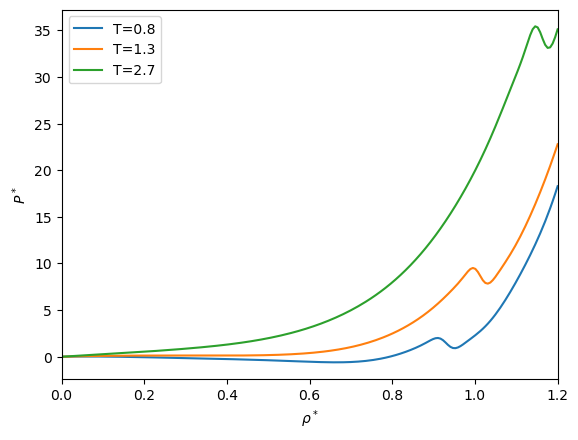

In [16]:
P1_plot = pressure_fun(alpha_plot, rhoad_plot, T1_plot)
P2_plot = pressure_fun(alpha_plot, rhoad_plot, T2_plot)
P3_plot = pressure_fun(alpha_plot, rhoad_plot, T3_plot)

plt.plot(rhoad_plot, P1_plot, label=f"T={T1}")
plt.plot(rhoad_plot, P2_plot, label=f"T={T2}")
plt.plot(rhoad_plot, P3_plot, label=f"T={T3}")
plt.xlim([0, 1.2])
plt.xlabel(r'$\rho^*$')
plt.ylabel(r'$P^*$')
plt.legend(loc='upper left')